In [ ]:
# CS 898AW - Spring 2025
# Group __ Project
#

Initial Grid:


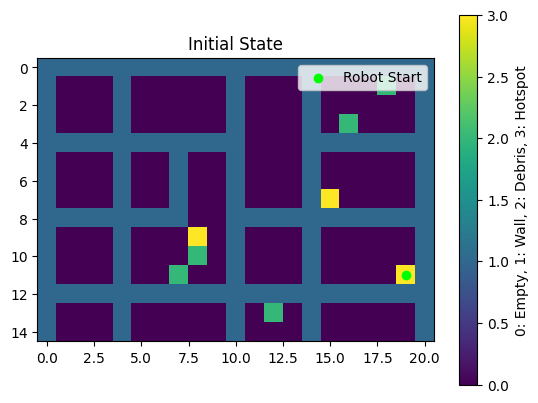

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Define grid dimensions (adjust as needed)
grid_rows = 15
grid_cols = 21
grid = np.zeros((grid_rows, grid_cols), dtype=int)

# Place walls (adjust based on our generic layout)
grid[0:1, :] = 1  # Top wall
grid[4:5, 0:11] = 1
grid[4:5, 14:] = 1
grid[8:9, 0:8] = 1
grid[8:9, 11:] = 1
grid[12:13, :] = 1 # Bottom wall
grid[:, 0:1] = 1  # Left wall
grid[:, 4:5] = 1
grid[:, 10:11] = 1
grid[:, 14:15] = 1
grid[:, 20:21] = 1 # Right wall
grid[5:9, 7:8] = 1 # Hallway wall
grid[1:5, 14:15] = 1 # Hallway wall
grid[9:13, 10:11] = 1 # Hallway wall

# Define starting position (Front Door - adjust based on grid)
start_pos = [11, 19] # Example: adjust based on where 'F' would be
robot_pos = np.array(start_pos).reshape(2, 1)
robot_cov = np.eye(2) * 0.1 # Initial small uncertainty

# Place random hazards (debris = 2) and hotspots (3)
num_hazards = 5
num_hotspots = 3
for _ in range(num_hazards):
    while True:
        row = random.randint(1, grid_rows - 2)
        col = random.randint(1, grid_cols - 2)
        if grid[row, col] == 0 and [col, row] != start_pos:
            grid[row, col] = 2
            break
for _ in range(num_hotspots):
    while True:
        row = random.randint(1, grid_rows - 2)
        col = random.randint(1, grid_cols - 2)
        if grid[row, col] == 0 and [col, row] != start_pos and grid[row, col] != 2:
            grid[row, col] = 3
            break

# Dictionary to store detected landmarks (initially empty)
landmarks = {} # Key: (row, col), Value: {'pos': np.array([[x], [y]]), 'cov': np.eye(2) * some_initial_uncertainty}

# Keep track of visited cells for simple mapping
mapped_grid = np.copy(grid)
robot_path = [start_pos]

print("Initial Grid:")
plt.imshow(mapped_grid)
plt.title("Initial State")
plt.colorbar(label="0: Empty, 1: Wall, 2: Debris, 3: Hotspot")
plt.scatter(start_pos[1], start_pos[0], color='lime', marker='o', label='Robot Start')
plt.legend()
plt.show()

In [ ]:
def get_valid_moves(pos, grid):
    row, col = pos
    # Ensure row and col are integers
    row, col = int(row), int(col)
    moves = []
    if row > 0 and grid[row - 1, col] != 1:
        moves.append([-1, 0])  # Up
    if row < grid.shape[0] - 1 and grid[row + 1, col] != 1:
        moves.append([1, 0])   # Down
    if col > 0 and grid[row, col - 1] != 1:
        moves.append([0, -1])  # Left
    if col < grid.shape[1] - 1 and grid[row, col + 1] != 1:
        moves.append([0, 1])   # Right
    return moves

def perform_movement(current_pos, grid):
    valid_moves = get_valid_moves(current_pos, grid)
    if not valid_moves:
        return [0, 0]  # No valid moves, stay put
    move = random.choice(valid_moves)
    return move

# Process noise covariance (adjust as needed)
Q = np.eye(2) * 0.01

# Simulate one time step of movement and prediction
def predict_step(robot_state, robot_covariance, control_input):
    # Prediction of the robot's next state
    predicted_state = robot_state + np.array(control_input).reshape(2, 1)
    # Prediction of the covariance (add process noise)
    predicted_covariance = robot_covariance + Q
    return predicted_state, predicted_covariance

# Example of one movement and prediction
control = perform_movement(robot_pos.flatten().tolist(), grid)
predicted_robot_pos, predicted_robot_cov = predict_step(robot_pos, robot_cov, control)

print("Control Input (delta x, delta y):", control)
print("Predicted Robot Position:\n", predicted_robot_pos)
print("Predicted Robot Covariance:\n", predicted_robot_cov)

robot_pos = predicted_robot_pos # Update robot's estimated position

Control Input (delta x, delta y): [-1, 0]
Predicted Robot Position:
 [[10]
 [19]]
Predicted Robot Covariance:
 [[0.11 0.  ]
 [0.   0.11]]


In [ ]:
def sense_environment(robot_pos_est, grid):
    row_r, col_r = np.round(robot_pos_est.flatten()).astype(int) # Robot's estimated integer position
    observations = []

    # Check surroundings (including current cell)
    for dr in [-1, 0, 1]:
        for dc in [-1, 0, 1]:
            row_obs, col_obs = row_r + dr, col_r + dc
            if 0 <= row_obs < grid.shape[0] and 0 <= col_obs < grid.shape[1]:
                feature = grid[row_obs, col_obs]
                if feature == 1:  # Wall
                    observations.append({'type': 'wall', 'relative_pos': np.array([[dc], [dr]])})
                elif feature == 2:  # Debris
                    observations.append({'type': 'debris', 'global_pos': np.array([[col_obs], [row_obs]])})
                elif feature == 3:  # Hotspot
                    observations.append({'type': 'hotspot', 'global_pos': np.array([[col_obs], [row_obs]])})
    return observations

In [ ]:
# Observation noise covariance (adjust as needed)
R = np.eye(2) * 0.5

def update_step(robot_state_pred, robot_cov_pred, observations, landmarks):
    updated_state = robot_state_pred.copy()
    updated_cov = robot_cov_pred.copy()
    new_landmarks = {}
    R_landmark = np.eye(2) * 0.1 # Observation noise for landmarks

    for obs in observations:
        if obs['type'] == 'wall':
            # Simplified wall update (can be expanded to treat walls as landmarks later)
            relative_pos = obs['relative_pos']
            predicted_wall_global = np.round(robot_state_pred + relative_pos).astype(int).flatten()
            if 0 <= predicted_wall_global[1] < grid.shape[0] and 0 <= predicted_wall_global[0] < grid.shape[1] and grid[predicted_wall_global[1], predicted_wall_global[0]] == 1:
                innovation = np.zeros((2, 1))
                H = np.eye(2)
                S = H @ updated_cov @ H.T + R
                K = updated_cov @ H.T @ np.linalg.inv(S)
                updated_state = updated_state + K @ innovation
                updated_cov = (np.eye(2) - K @ H) @ updated_cov

        elif obs['type'] == 'debris' or obs['type'] == 'hotspot':
            global_pos_observed = obs['global_pos']
            landmark_id = tuple(global_pos_observed.flatten().tolist())

            if landmark_id not in landmarks:
                # Initialize new landmark
                landmarks[landmark_id] = {
                    'pos': robot_state_pred + (global_pos_observed - np.round(robot_state_pred).astype(int).reshape(2, 1)),
                    'cov': np.eye(2) * 1.0
                }
                new_landmarks[landmark_id] = landmarks[landmark_id]
            else:
                # EKF update for existing landmark
                landmark = landmarks[landmark_id]
                predicted_observation = landmark['pos'] - updated_state
                z = (global_pos_observed - np.round(updated_state).astype(int).reshape(2, 1)) # Observed relative position

                Hr = -np.eye(2)
                Hl = np.eye(2)
                Sl = Hr @ updated_cov @ Hr.T + Hl @ landmark['cov'] @ Hl.T + R_landmark
                Kl = updated_cov @ Hr.T @ np.linalg.inv(Sl)
                updated_state = updated_state + Kl @ (z - predicted_observation)
                updated_cov = (np.eye(2) - Kl @ Hr) @ updated_cov

                # Update landmark covariance (we'll do this more carefully later to avoid inconsistencies)
                # landmarks[landmark_id]['pos'] = landmark['pos'] + Hl @ landmark['cov'] @ np.linalg.inv(Sl) @ (z - predicted_observation)
                # landmarks[landmark_id]['cov'] = (np.eye(2) - Hl @ landmark['cov'] @ np.linalg.inv(Sl) @ Hl) @ landmark['cov']

    return updated_state, updated_cov, landmarks, new_landmarks

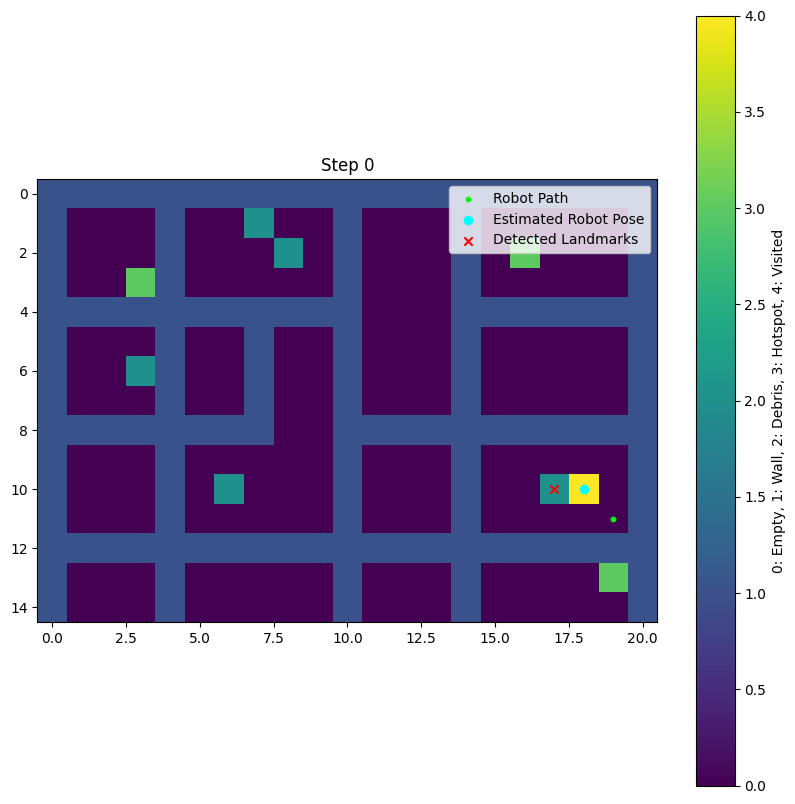

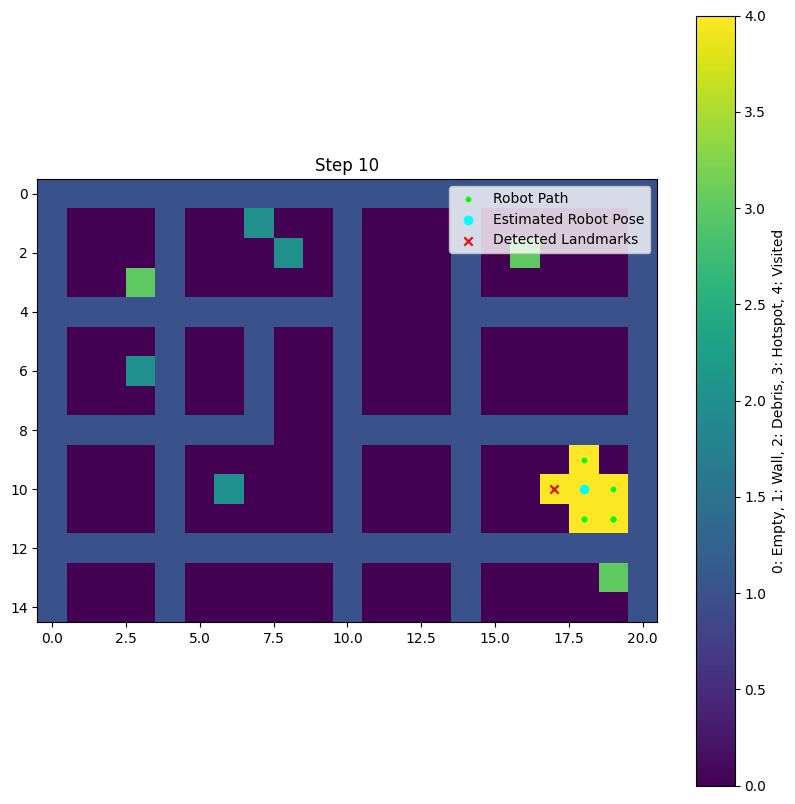

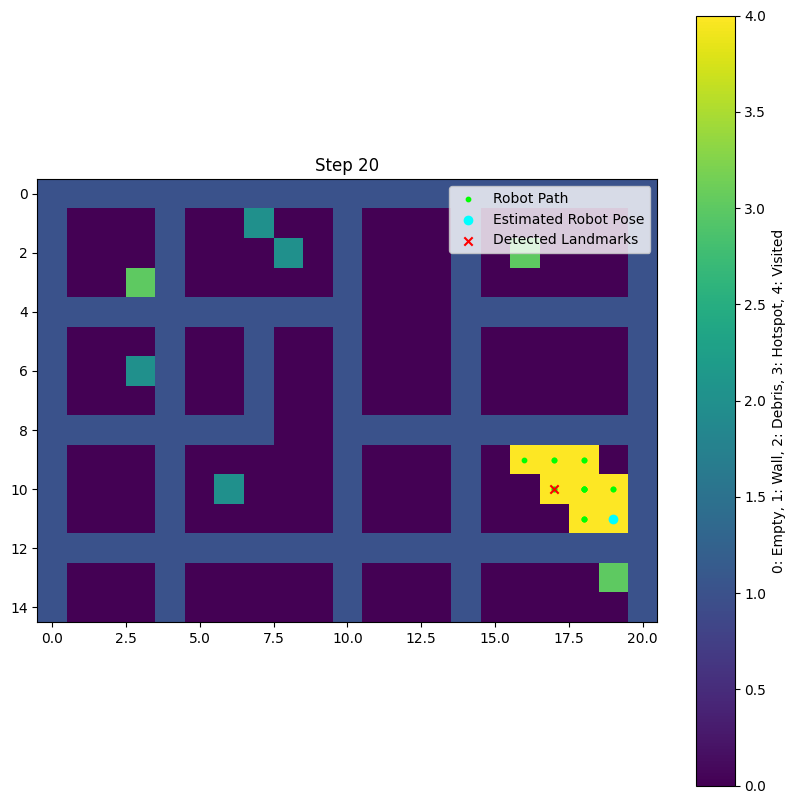

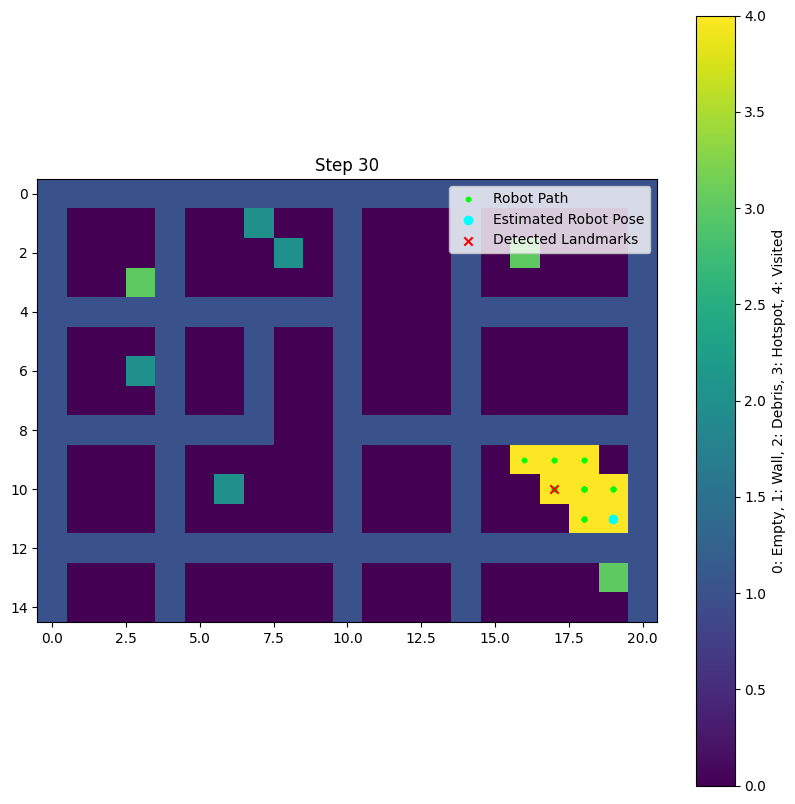

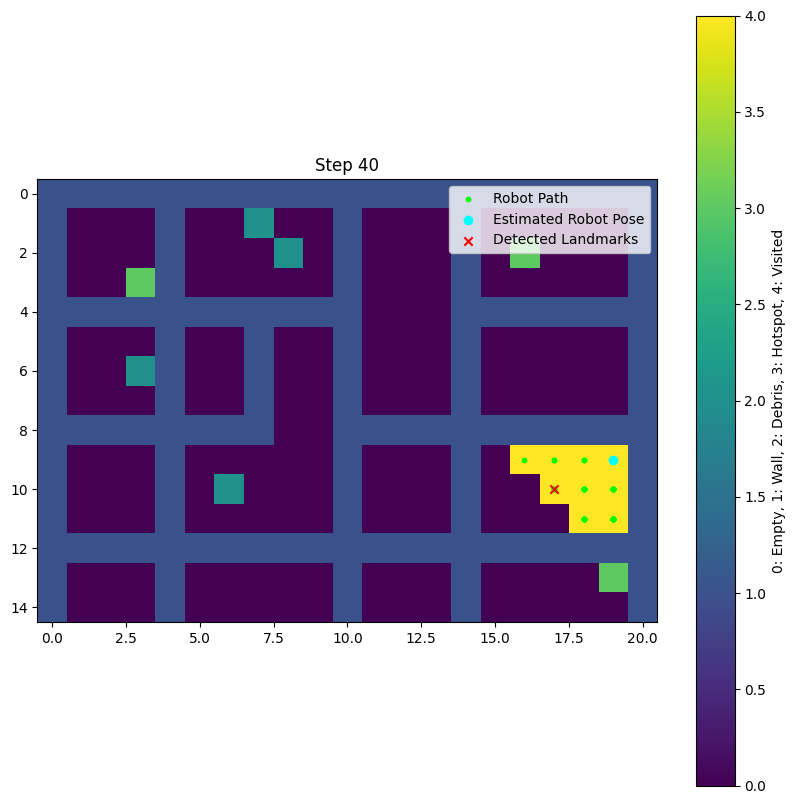

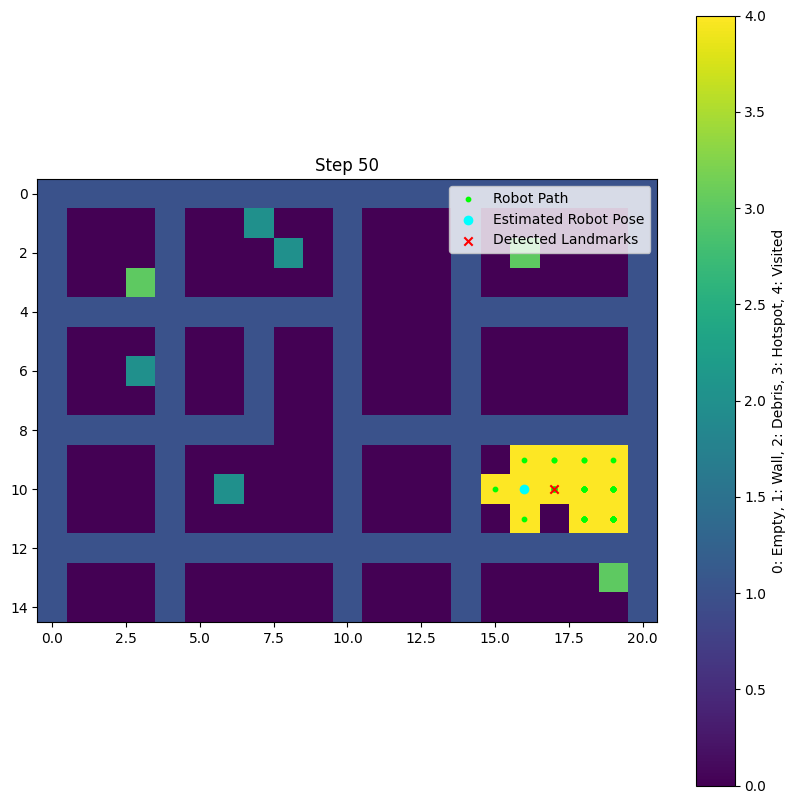

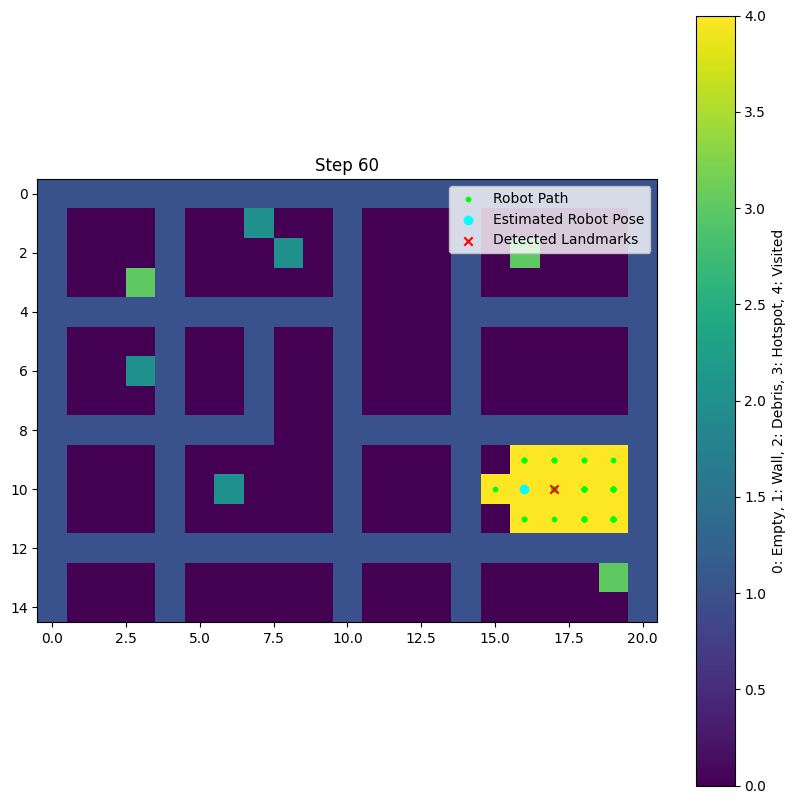

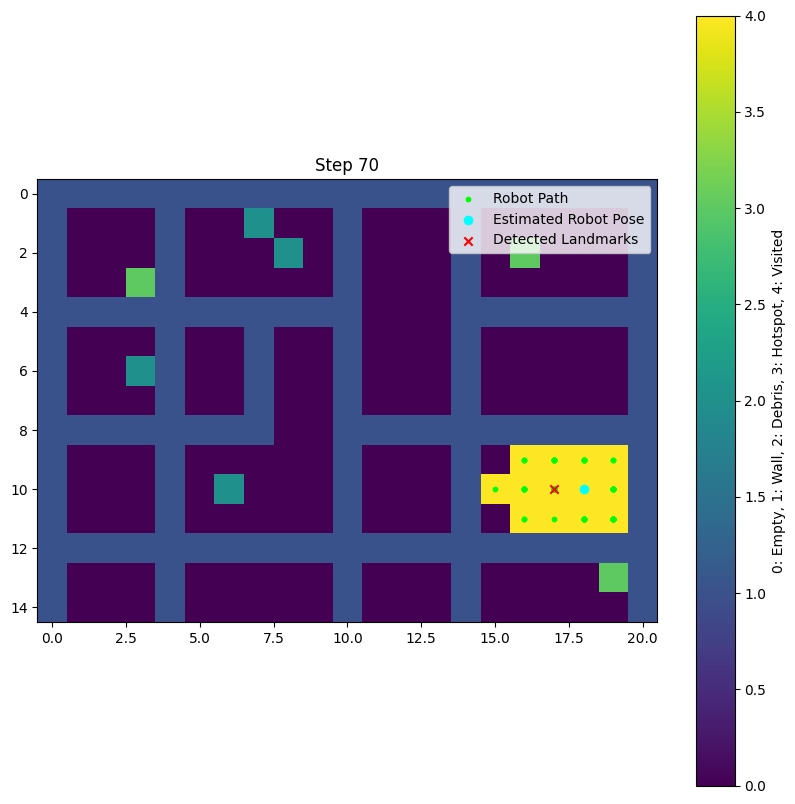

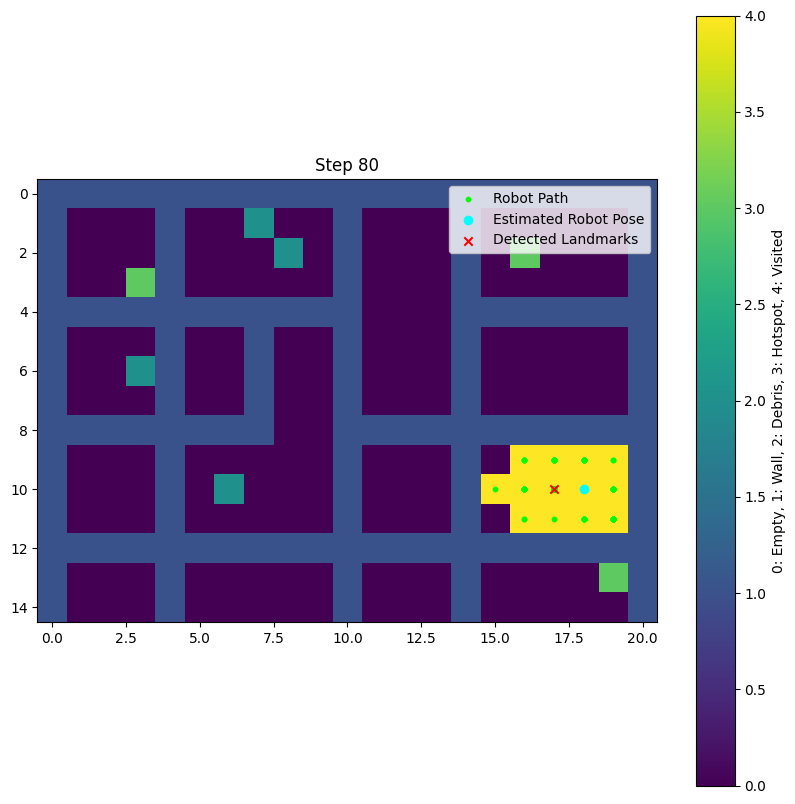

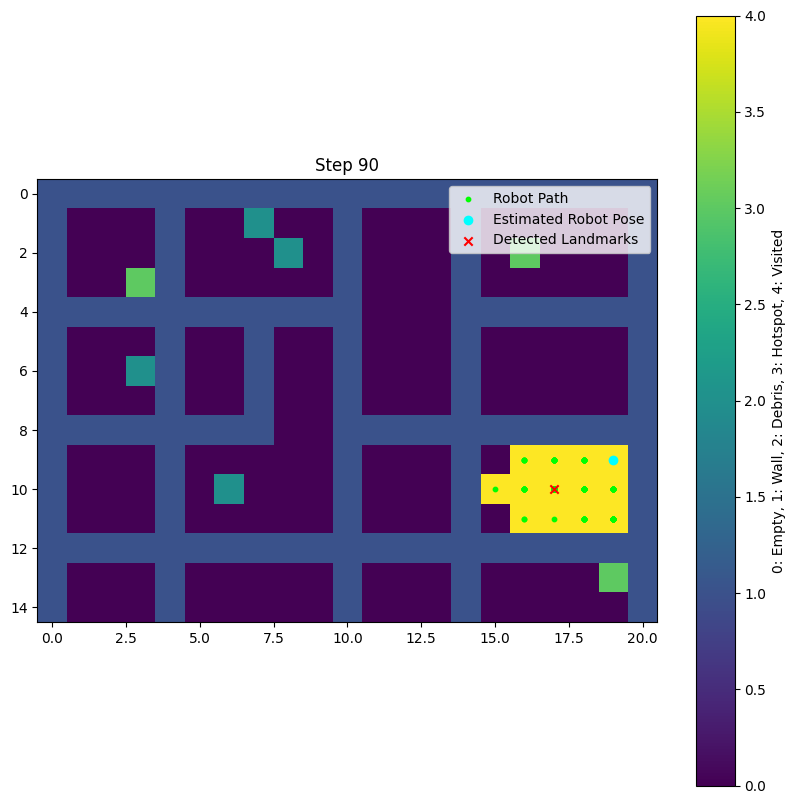

Final Landmarks: {(17, 10): {'pos': array([[17],
       [10]]), 'cov': array([[1., 0.],
       [0., 1.]])}}


In [ ]:
num_steps = 100
for i in range(num_steps):
    # 1. Movement
    control = perform_movement(robot_pos.flatten().tolist(), grid)
    robot_path.append((robot_pos[0, 0] + control[0], robot_pos[1, 0] + control[1]))
    robot_pos_pred, robot_cov_pred = predict_step(robot_pos, robot_cov, control)

    # 2. Sensing
    observations = sense_environment(robot_pos_pred, grid)

    # 3. Update
    robot_pos, robot_cov, landmarks, new_landmarks = update_step(robot_pos_pred, robot_cov_pred, observations, landmarks)

    # Update mapped grid (simple exploration)
    row_r, col_r = np.round(robot_pos).astype(int).flatten()
    if 0 <= row_r < mapped_grid.shape[0] and 0 <= col_r < mapped_grid.shape[1]:
        mapped_grid[row_r, col_r] = 4 # Mark as visited

    # Visualization (every few steps)
    if i % 10 == 0:
        plt.figure(figsize=(10, 10))
        plt.imshow(mapped_grid)
        plt.title(f"Step {i}")
        plt.colorbar(label="0: Empty, 1: Wall, 2: Debris, 3: Hotspot, 4: Visited")
        plt.scatter([p[1] for p in robot_path], [p[0] for p in robot_path], color='lime', s=10, label='Robot Path')
        plt.scatter(robot_pos[1], robot_pos[0], color='cyan', marker='o', label='Estimated Robot Pose')

        landmark_x = [lm['pos'][0, 0] for lm in landmarks.values()]
        landmark_y = [lm['pos'][1, 0] for lm in landmarks.values()]
        plt.scatter(landmark_x, landmark_y, color='red', marker='x', label='Detected Landmarks')

        plt.legend()
        plt.show()

print("Final Landmarks:", landmarks)

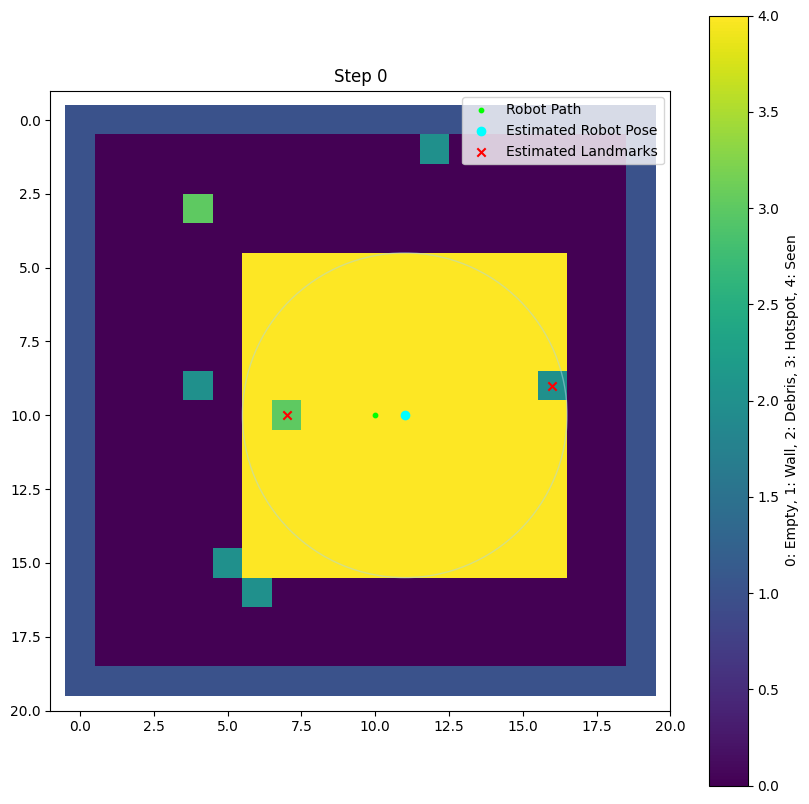

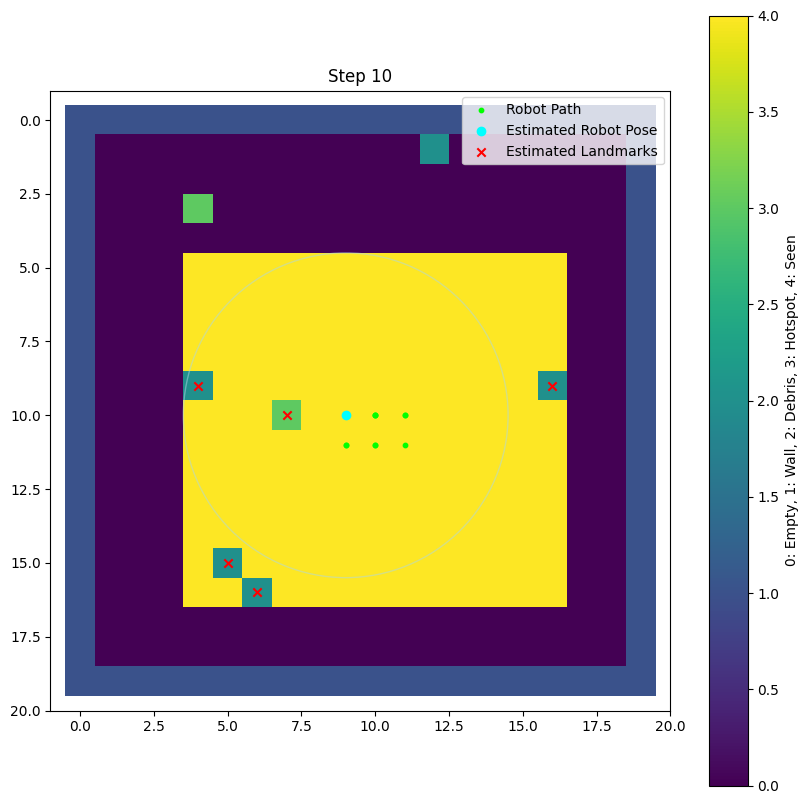

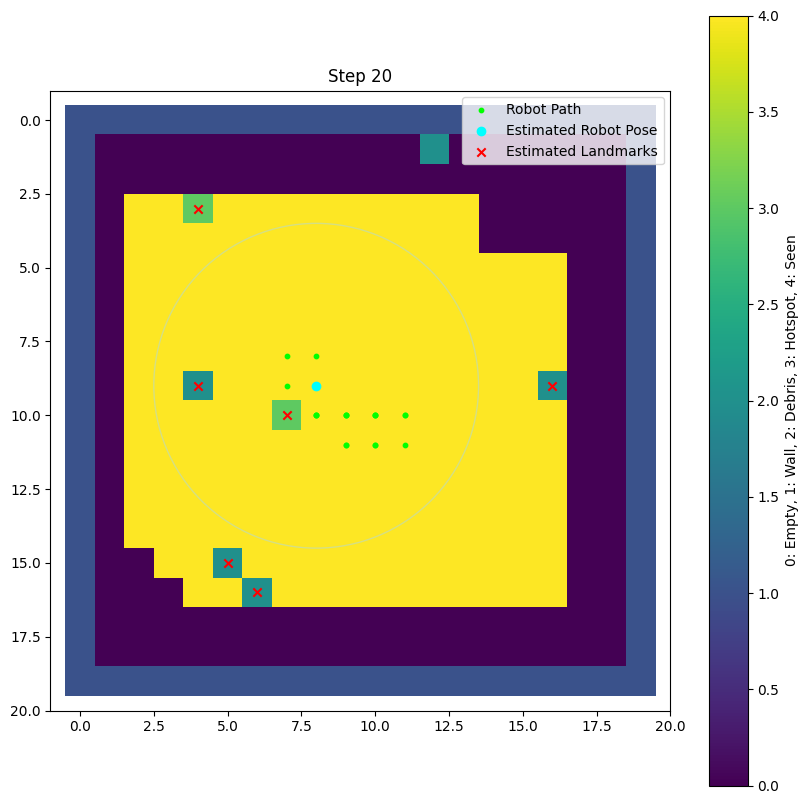

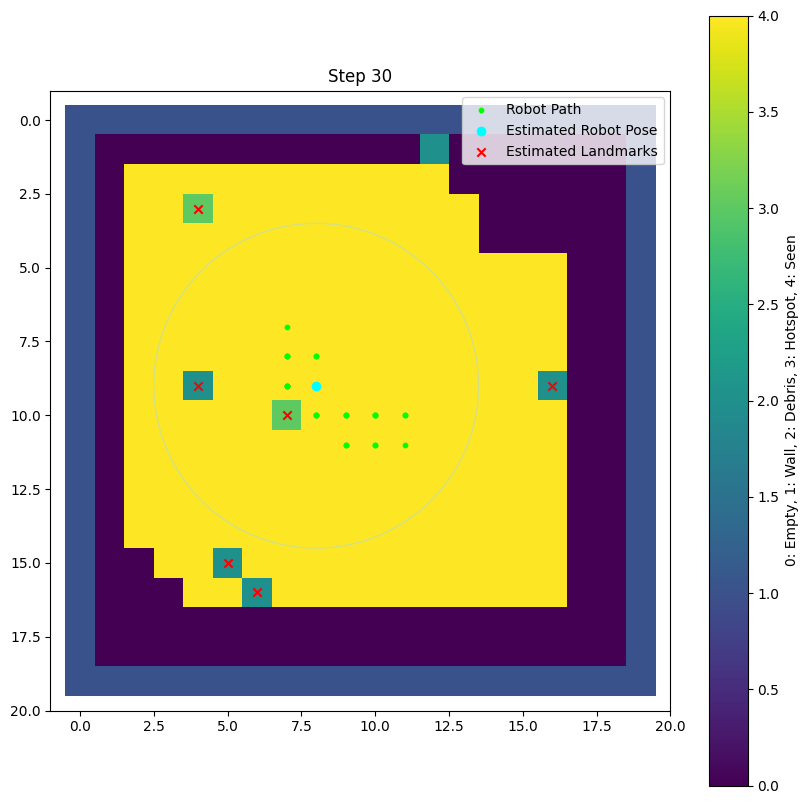

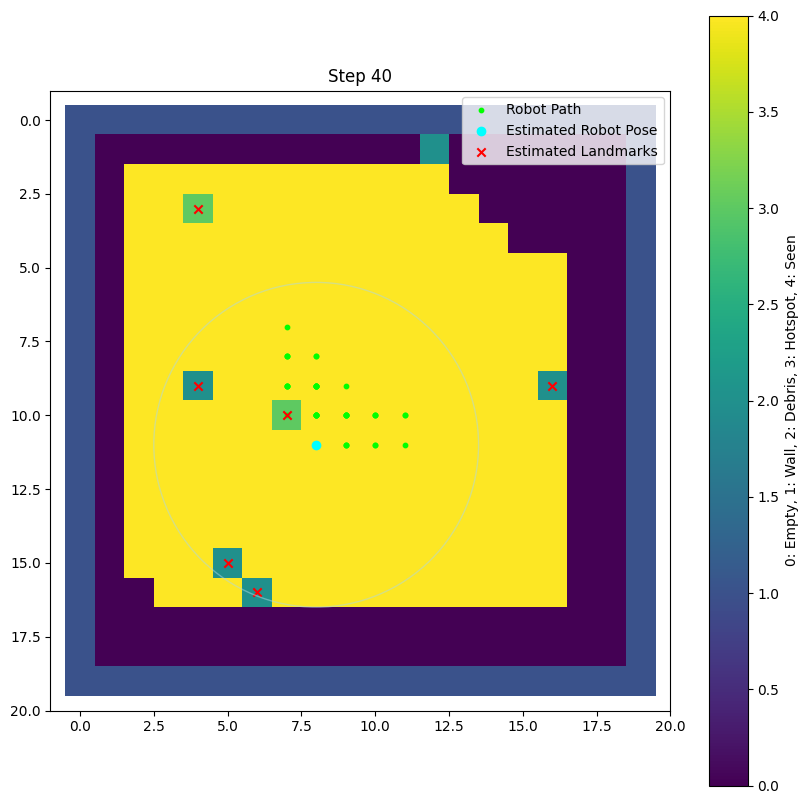

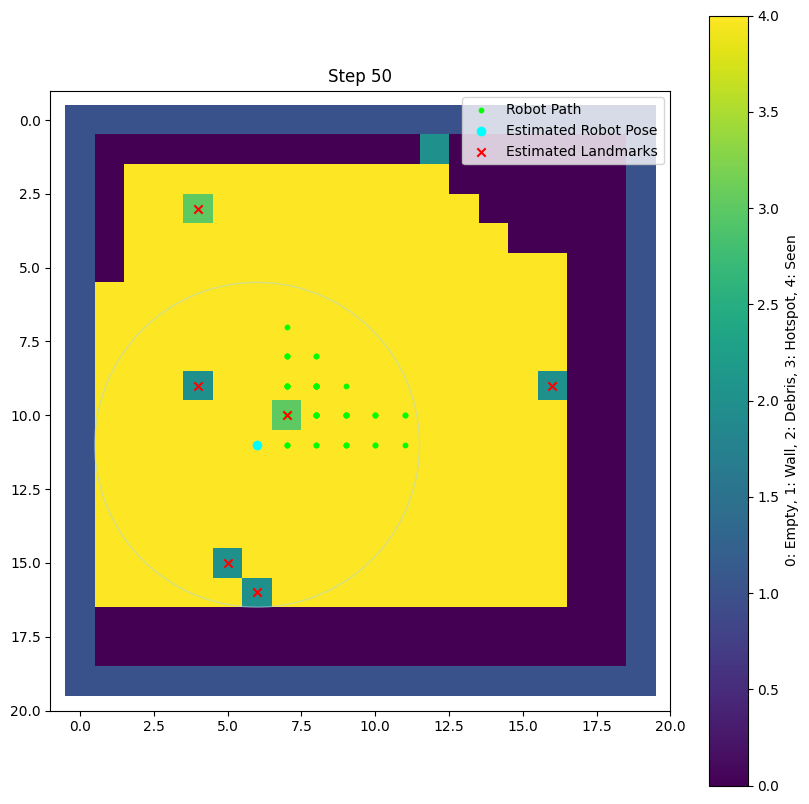

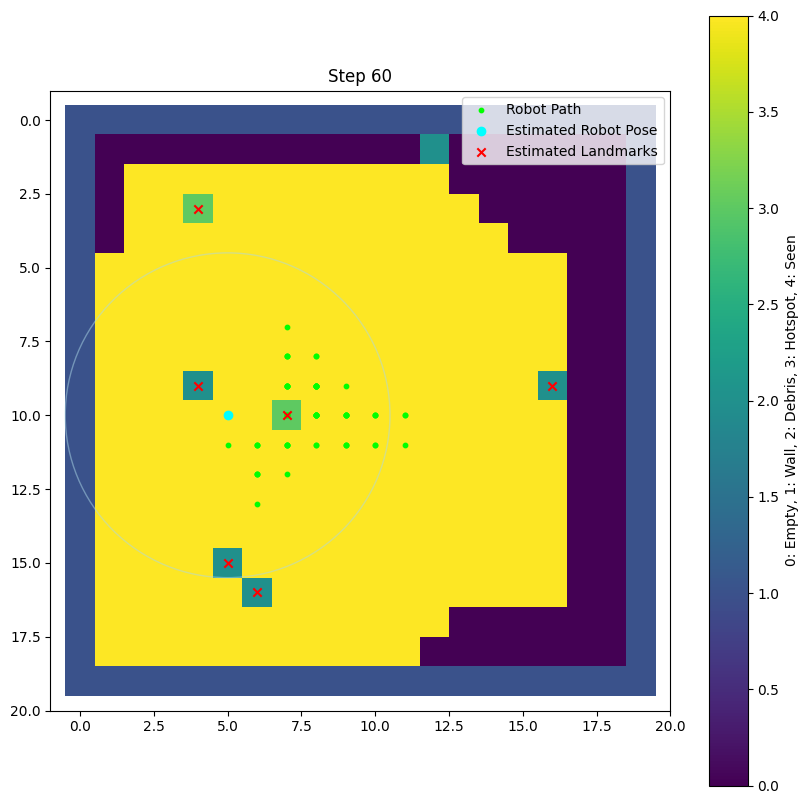

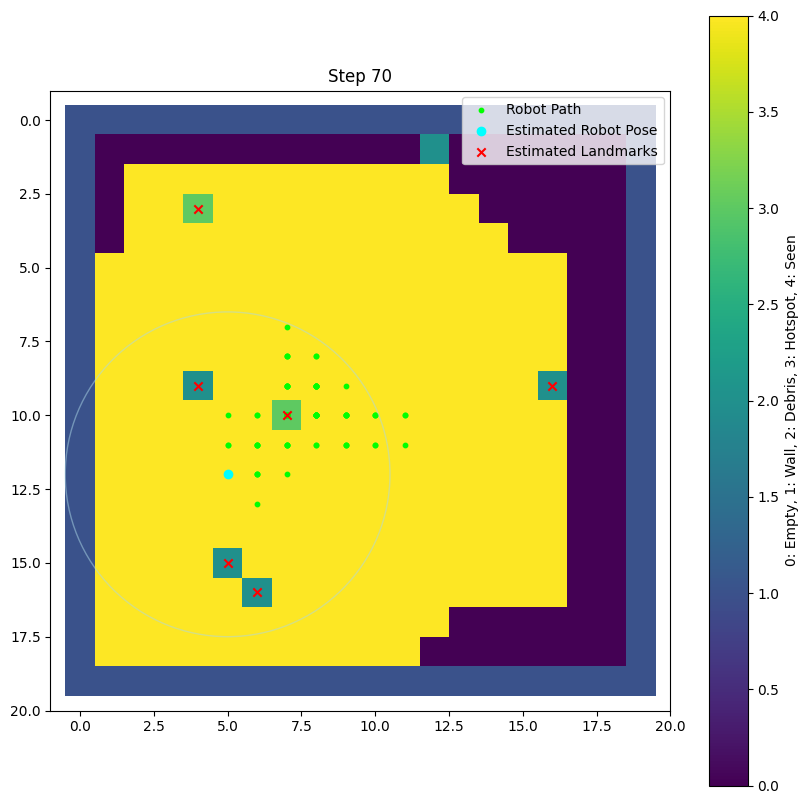

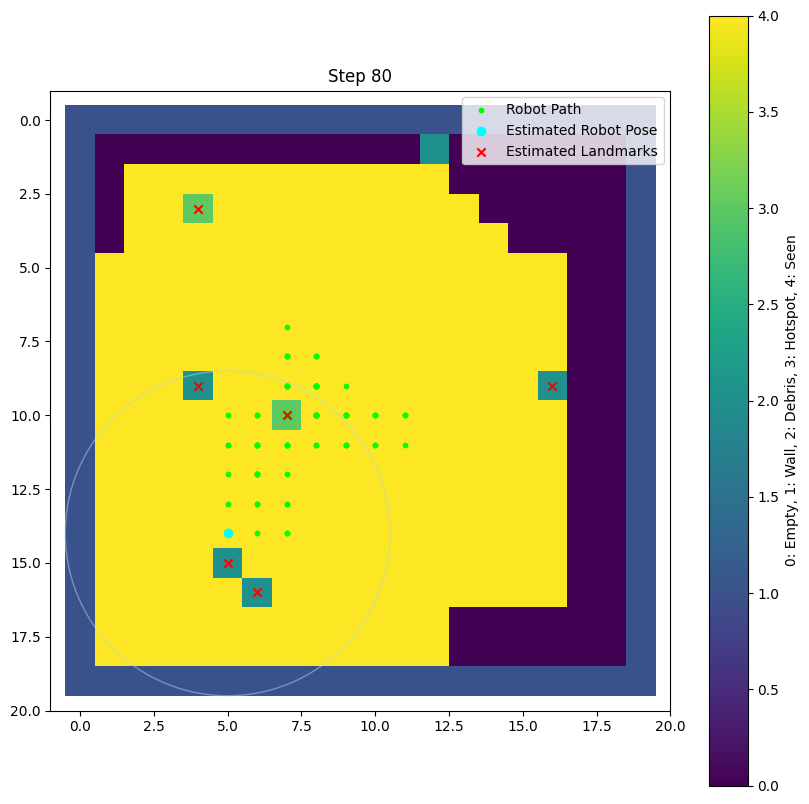

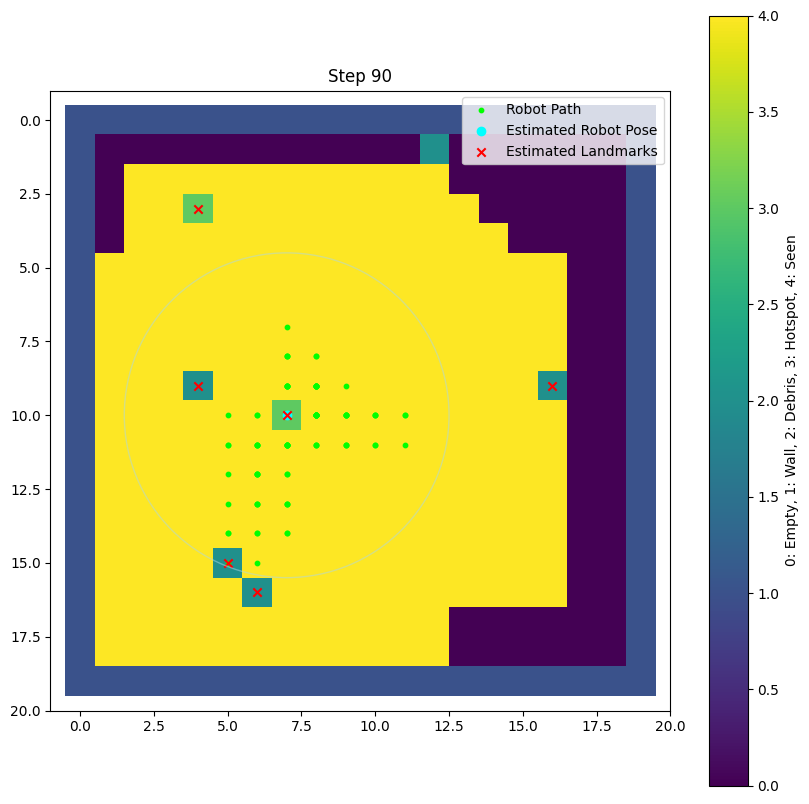

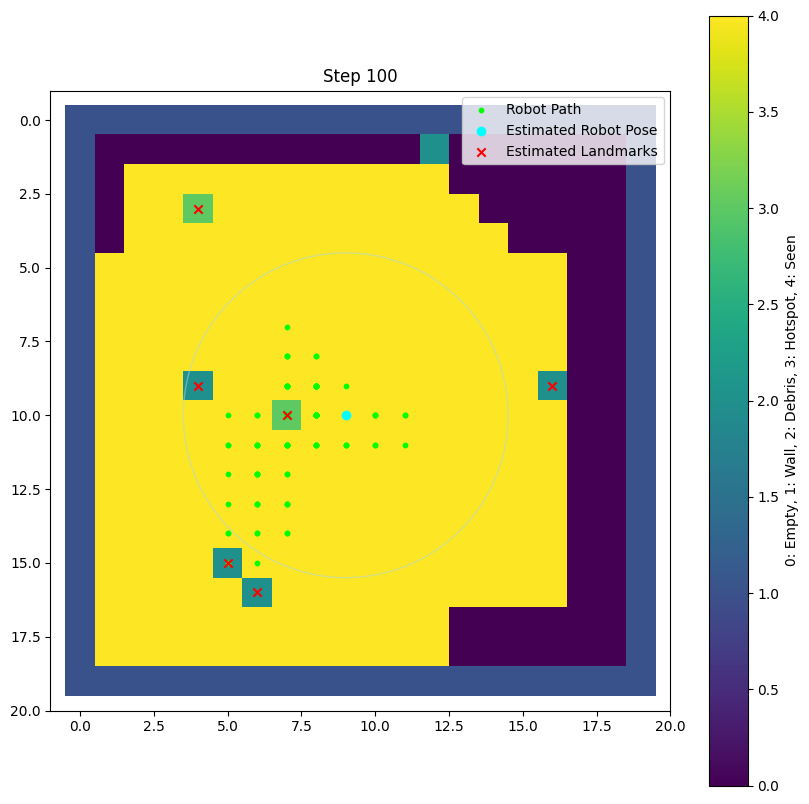

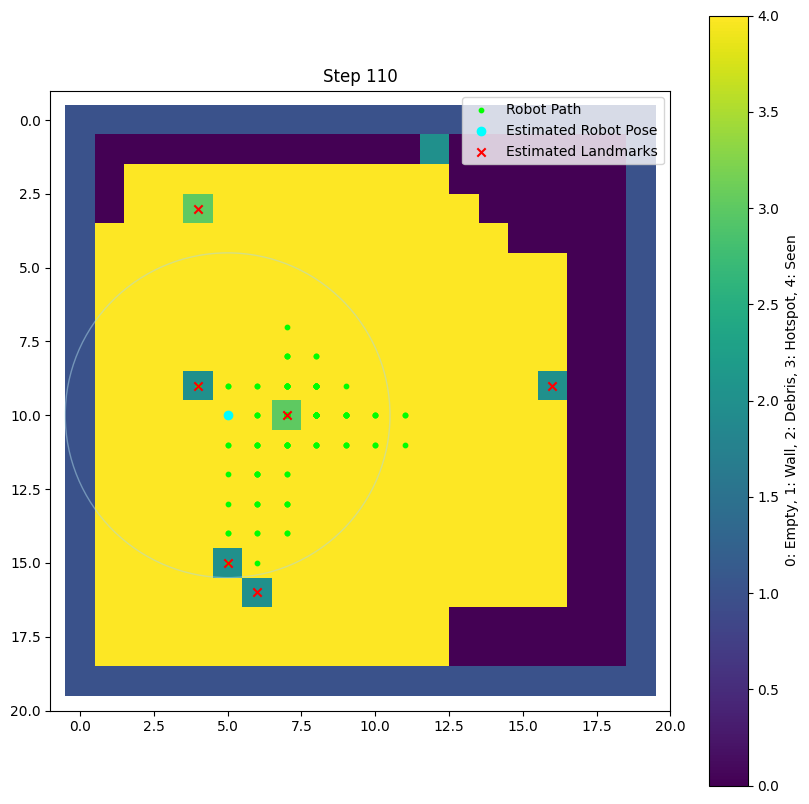

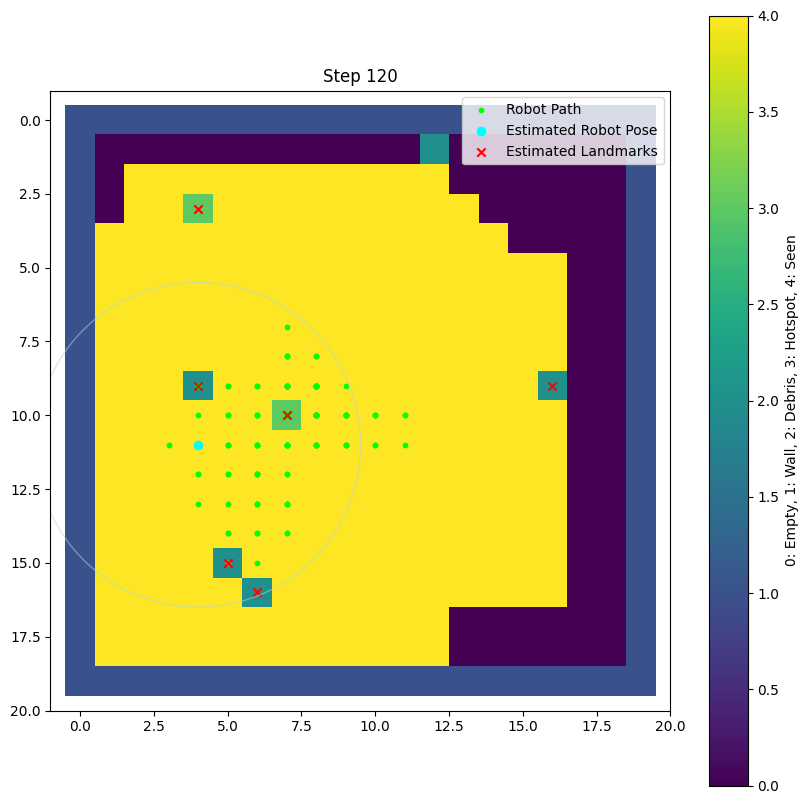

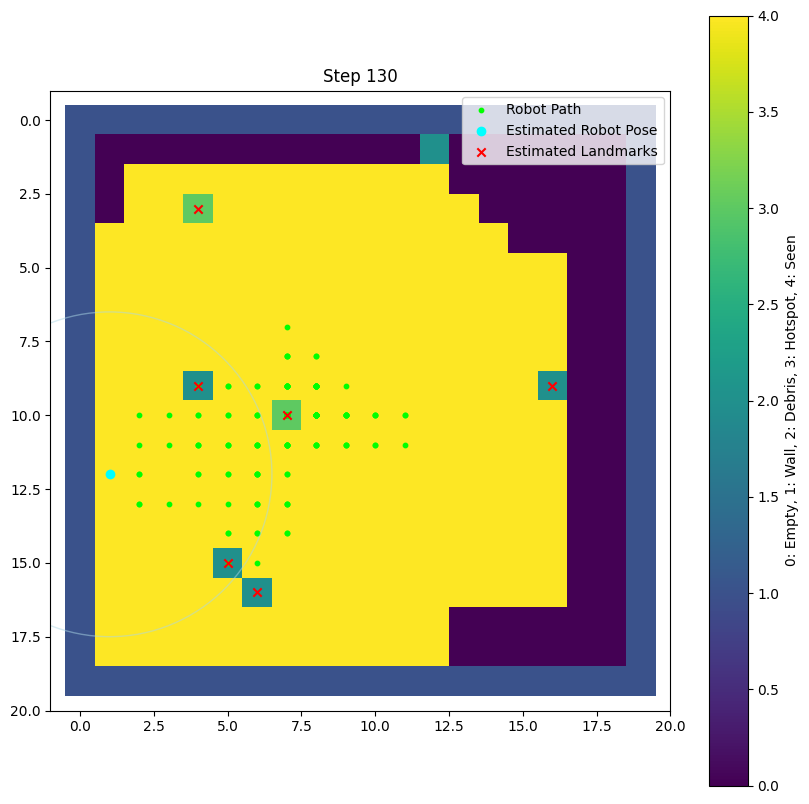

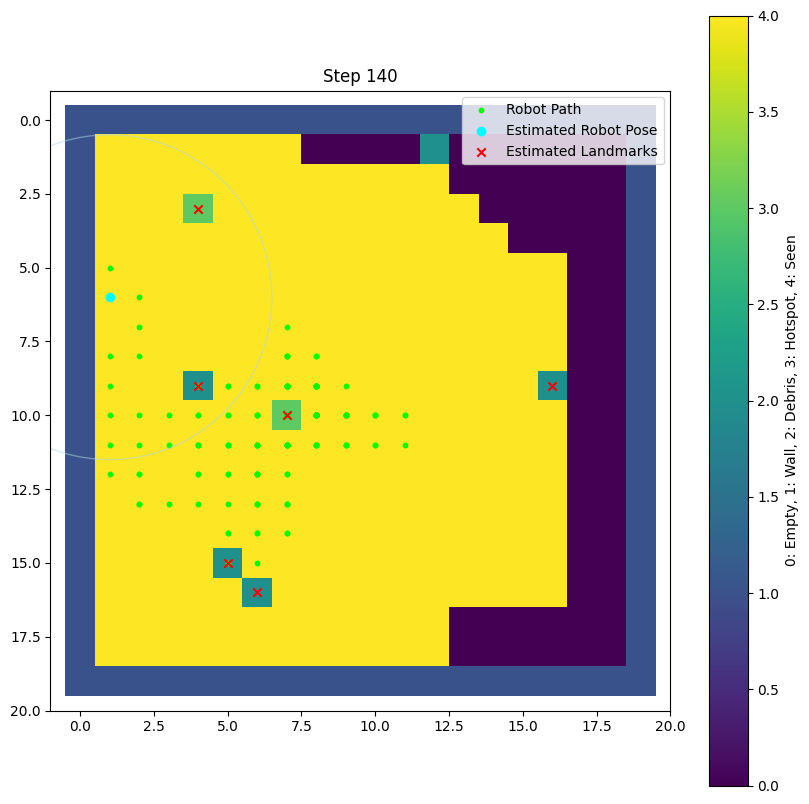

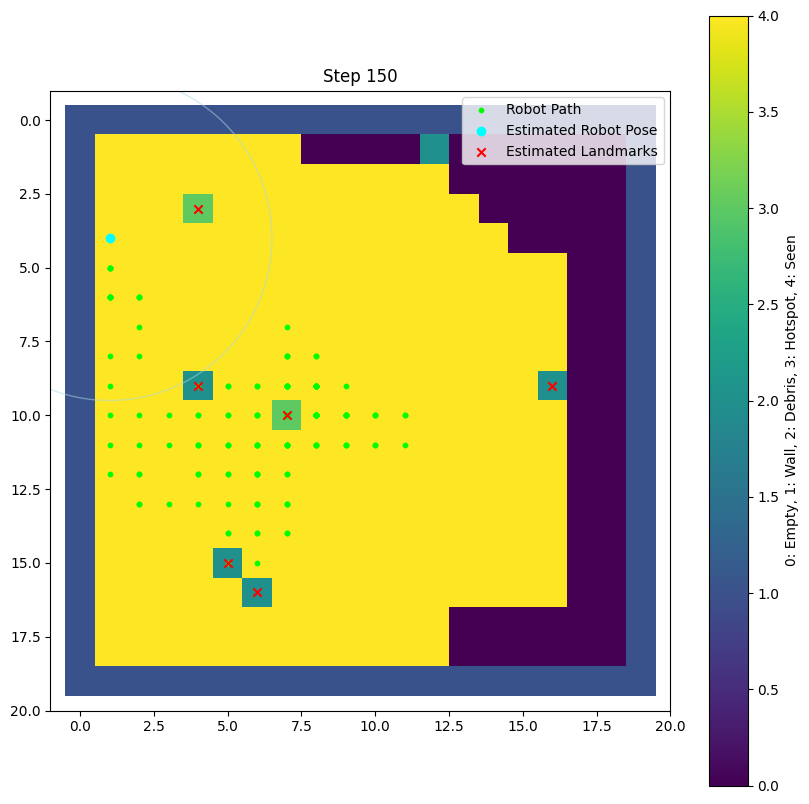

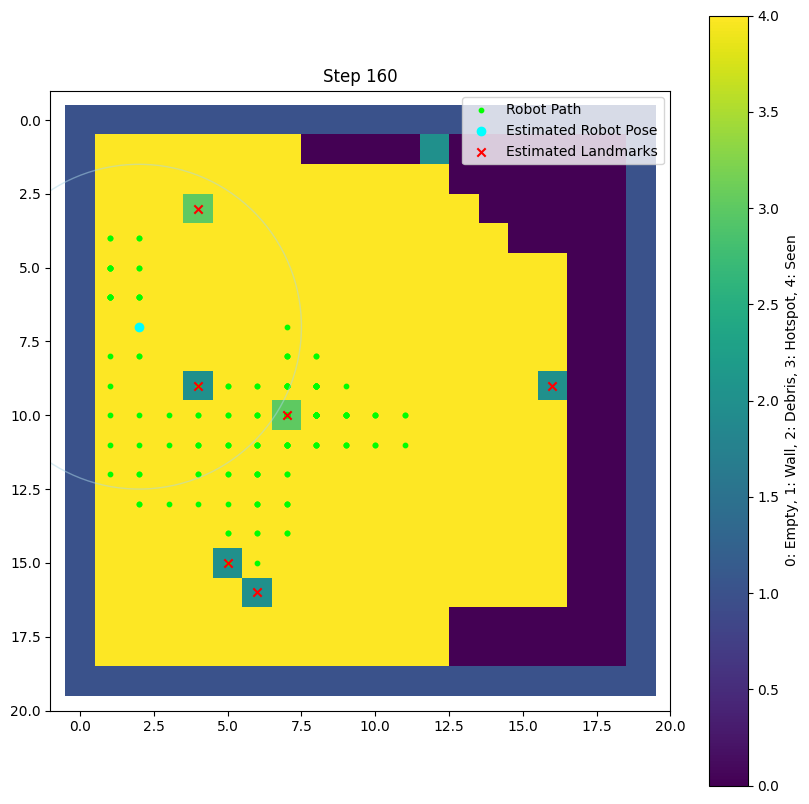

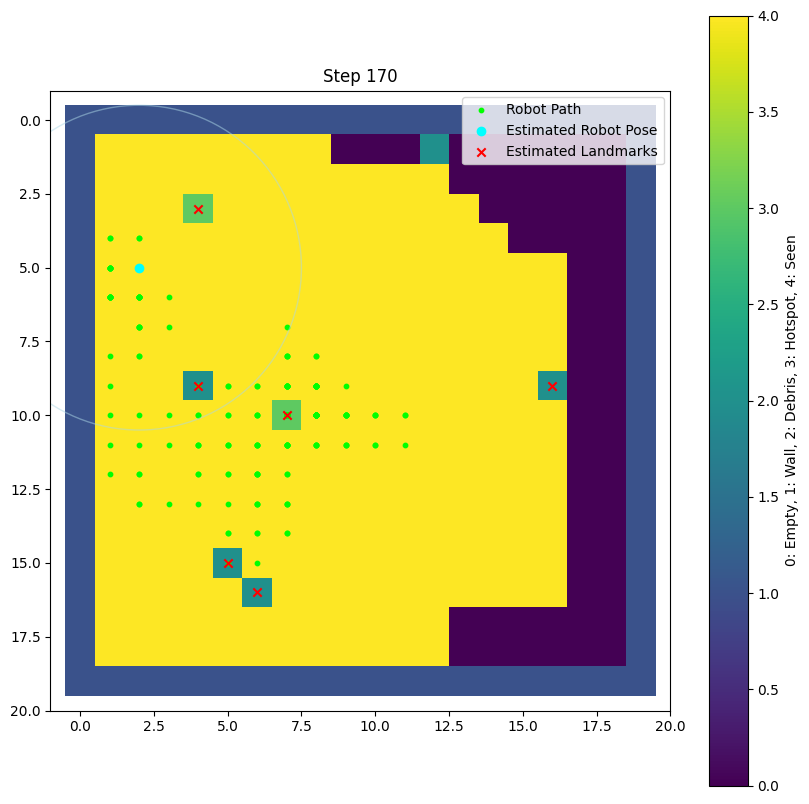

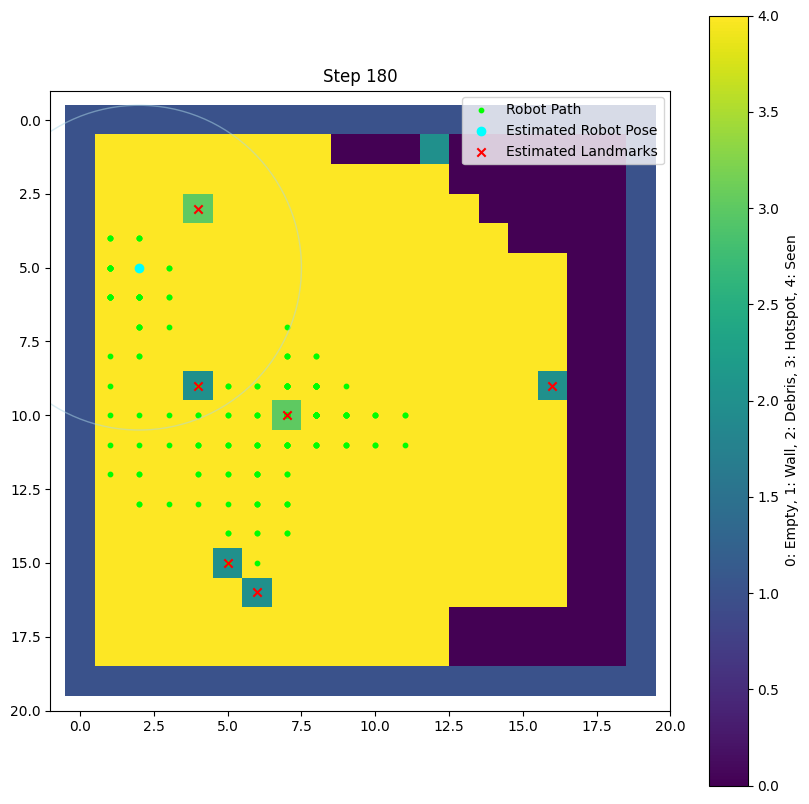

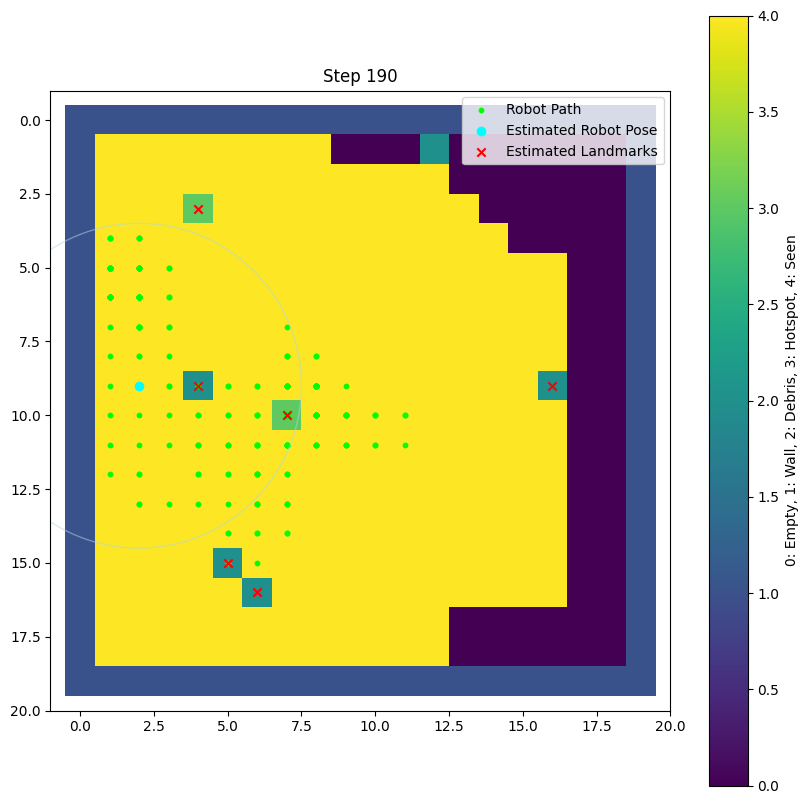

Final Landmarks: {(16, 9): {'pos': array([[16.],
       [ 9.]]), 'cov': array([[0.0756925, 0.       ],
       [0.       , 0.0756925]])}, (7, 10): {'pos': array([[ 7.],
       [10.]]), 'cov': array([[0.00070076, 0.        ],
       [0.        , 0.00070076]])}, (6, 16): {'pos': array([[ 6.],
       [16.]]), 'cov': array([[0.00188981, 0.        ],
       [0.        , 0.00188981]])}, (5, 15): {'pos': array([[ 5.],
       [15.]]), 'cov': array([[0.00114092, 0.        ],
       [0.        , 0.00114092]])}, (4, 9): {'pos': array([[4.],
       [9.]]), 'cov': array([[0.00062413, 0.        ],
       [0.        , 0.00062413]])}, (4, 3): {'pos': array([[4.],
       [3.]]), 'cov': array([[0.00177372, 0.        ],
       [0.        , 0.00177372]])}}
